# Avaliando _overfitting_ e _underfitting_ com o conjunto de dados iris

Nessa prática tentaremos entender como e porque os fenômenos de sub e sobreajuste podem ocorrer ao lidar com algoritmos de aprendizado de máquina.

Como tarefa proposta para a tutoria, o conjunto de dados iris deve ser utilizado. Esse conjunto está disponível na biblioteca `sklearn`, que é hoje uma das grades referências para aprendizado de máquina utilizando Python.

Iniciaremos explorando um pouco esse conjunto (clássico de dados).

**Observação:** adicionei a importação dos pacotes à medida que eles vão sendo utilizados para introduzir conceitos e ferramentas aos poucos (não segue as melhores práticas de programação, assim como os notebooks não o fazem geralmente :P).

### Começamos carregando os dados

In [1]:
from sklearn import datasets

iris = datasets.load_iris()

# Vamos descobrir que campos temos nos dados
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

### Agora iremos ver quais as classes e atributos do problema (tipos de íris)

In [2]:
print('Classes:', iris['target_names'])
print('Atributos descritivos:', iris['feature_names'])
print('Número de exemplos na base de dados:', len(iris['data']))
iris['data'][:3, :]

Classes: ['setosa' 'versicolor' 'virginica']
Atributos descritivos: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Número de exemplos na base de dados: 150


array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2]])

### Vamos extrair algumas informações básicas dos dados antes de prosseguirmos

In [3]:
import numpy as np

X, y = iris['data'], iris['target']


print('#Instâncias com dados faltantes:', sum(np.any(np.isnan(X), axis=1)))
print('Média dos atributos:', np.mean(X, axis=0))
print('Desvio padrão:', np.std(X, axis=0))
print('Valores máximos por atributo:', np.max(X, axis=0))
print('Valores mínimos por atributo:', np.min(X, axis=0))

#Instâncias com dados faltantes: 0
Média dos atributos: [5.84333333 3.05733333 3.758      1.19933333]
Desvio padrão: [0.82530129 0.43441097 1.75940407 0.75969263]
Valores máximos por atributo: [7.9 4.4 6.9 2.5]
Valores mínimos por atributo: [4.3 2.  1.  0.1]


**Em suma:** dataset simples e "bem comportado". Comumente utilizado para propósitos didáticos.

Antes de prosseguirmos, que tal tentarmos entender como se dão as relações entre atributos e as classes? Para tal, utilizaremos recursos de visualização de dados. A ideia aqui é tentarmos entender quão "difícil" a tarefa de classificar os tipos de íris dados os descritores que temos.

_Wait_ : temos quatro atributos descritivos e tipicamente (exceto em filmes como Interestelar) estamos limitados a três dimensões. Como iremos visualizar as relações entre os dados? R: técnicas de projeção de dados:

**Principal Component Analysis** ([PCA](https://datasciencesamurai.com/step-by-step-principal-component-analysis-pca-python))

* Técnica de redução de dimensionalidade
* Utiliza transformações lineares nos dados
* Não precisamos focar em detalhes nesse momento. Basta sabermos agora que esse algoritmo poderá nos auxiliar com a visualização dos dados

Iremos aplicar PCA nos dados da base iris e reduziremos o número de dimensões para que possamos visualizar as relações existentes nos dados. O `sklearn` nos provê as ferramentas necessárias para tal.

In [4]:
from sklearn.preprocessing import StandardScaler  # padronização dos dados antes da PCA
from sklearn.decomposition import PCA  # PCA propriamente dita

X_norm = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=2).fit_transform(X_norm)

X_pca[:2, :]

array([[-2.26470281,  0.4800266 ],
       [-2.08096115, -0.67413356]])

Agora vamos visualizar a representação compacta que obtemos:

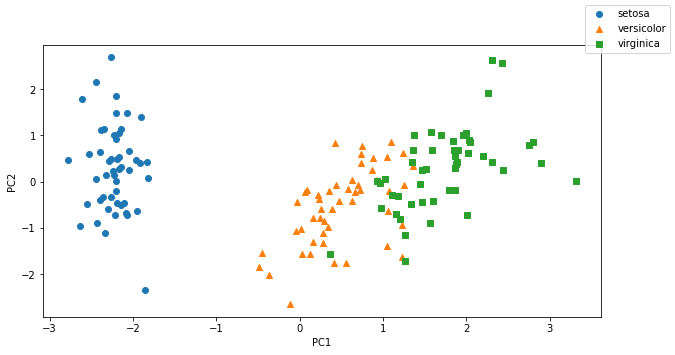

In [5]:
import matplotlib.pyplot as plt

markers = ['o', '^', 's']
fig, ax = plt.subplots(figsize=(10, 5))
for class_id, class_name in enumerate(iris['target_names']):
    imask = y == class_id
    ax.scatter(X_pca[imask, 0], X_pca[imask, 1], label=class_name, marker=markers[class_id])
fig.legend()
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

**Cool, huh?**

OK, projeção de dados parece algo muito legal e tudo mais, mas será que não dá para simplificar um pouco mais as coisas (matematicamente falando)? Nesse caso... sim. Podemos utilizar outras alternativas que não se baseiam em projeções, autovalores, autovetores e cia.

Existe uma técnica de visualização de dados muito interessante que é chamada de _Radviz_ :

* Utiliza a abstração de um sistema de molas
* Cada atributo descritivo é um ponto de "âncora" onde prendemos uma mola até cada uma das amostras da base dados
* Podemos ajustar diferentes pesos para cada atributo, o que implica em alterar a tensão das molas

Podemos utilizar o Radviz em várias plataformas, mas aqui utilizaremos o software [Orange](https://orange.biolab.si).

(Pausa para plotting)

-> Já voltamos para cá


## Separando dados de interesse do conjunto para avaliar algoritmos de aprendizado de máquina

Como havia mencionado anteriormente, o conjunto _iris_ é normalmente utilizado para propósitos didáticos e é muito simples. Podemos perceber que uma das classes (setosa) pode ser facilmente separada linearmente das outras.

Como o nosso objetivo aqui é entender os conceitos de _overfitting_ e _underfitting_ e não queremos nos ater em demasia em conceitos extras, iremos simplificar ainda mais esse problema e focar na porção que não é linearmente separável.


Vamos selecionar apenas as classes _versicolor_ e _virginica_.

In [6]:
print('Classe 0:', iris['target_names'][0])

imask = y == 0
X, y = X[~imask, :], y[~imask]
print(X.shape, y.shape)

Classe 0: setosa
(100, 4) (100,)


### Separando o conjunto em treino e teste

Para analisarmos sub e sobreajuste, precisaremos de um conjunto de dados para induzirmos um modelo e outro
conjunto que nunca foi visto pelo modelo. O primeiro conjunto é chamado de conjunto de treinamento e o segundo
de conjunto de teste. Utilizaremos 80% dos dados para treinamento e 20% para testes.

**Observação**: vale ressaltar que essa é uma abordagem simplista e, na pratica, outras estratégias deveriam ser utilizadas. No entanto, para nossos propósitos didáticos reservar aleatoriamente um porção dos dados para testes é suficiente.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

## Pontos importantes a se considerar antes de iniciarmos:

* Tarefa preditiva extremamente simples
* Selecionamos os exemplos de treino e teste de forma aleatória
    - Não temos garantias que os exemplos mais difíceis estarão no conjunto de teste (treino)
    
## Como avaliaremos *overfitting* e *underfitting*?

Uma forma simples é monitorar a variação das curvas de erro nos conjuntos de treinamento e teste (eixo y) com relação a algum hiperparâmetro do algoritmo de AM.

Notem que exploraremos apenas um hiperparâmetro por vez nessa análise.

## Iniciaremos com a análise de uma variante do algoritmo _k-Nearest Neighbors_ (k-NN)
### Radius Neighbors

Para Radius Neighbors, um exemplo é classificado de acordo com os vizinhos que se encontram dentro de uma hiper-esfera (no caso de duas dimensões, uma hiper-esfera é um círculo) com raio pré-determinado. A classe com mais exemplos dentro da hiper-esfera define a classe daquele exemplo com classe desconhecida. Caso nenhum exemplo com classe conhecida esteja dentro da hiper-esfera, o classificador prediz uma classe padrão pré-determinada.

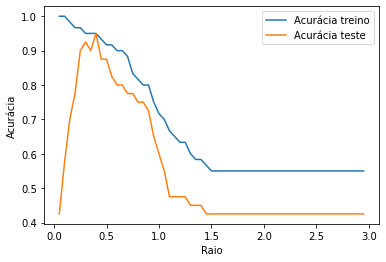

In [8]:
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

minmaxs = MinMaxScaler()

X_train_scaled = minmaxs.fit_transform(X_train)
X_test_scaled = minmaxs.transform(X_test)

train_accs = []
test_accs = []

r_values = []

for r in np.arange(0.05, 3, 0.05):
    r_values.append(r)
    knn = RadiusNeighborsClassifier(radius=r, outlier_label = 1, p = 2)
    knn.fit(X_train_scaled, y_train)
    
    train_pred = knn.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    train_accs.append(train_acc)
    
    test_pred = knn.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    test_accs.append(test_acc)
    
plt.plot(r_values, train_accs, label='Acurácia treino')
plt.plot(r_values, test_accs, label='Acurácia teste')
plt.xlabel('Raio')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

---
### Vamos analisar algumas possibilidades para resolver a tarefa proposta
---

## _k-Nearest Neighbors_ (k-NN)


O k-NN é baseado em distâncias, assim como apresentado na aula. Não existe um modelo propriamente dito a ser gerado, por essa razão tal algoritmo é denominado *lazy*. Para cada nova instância de consulta, o algoritmo k-NN procura em sua base de consulta (base de conhecimento, ou conjunto de treinamento) os `k` exemplos mais similares com o novo exemplo recebido. A classe atribuida a esse novo exemplo é aquela que aparece mais vezes dentre os `k` vizinhos mais próximos selecionados (função *moda*).

Por ser um algoritmo baseado em distâncias, normalizaremos os valores dos atributos para fiquem no intervalo de `[0, 1]` e, assim, tenham o mesmo "peso" no cálculo das distâncias.

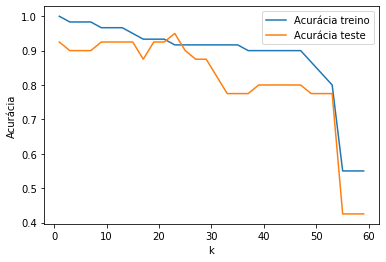

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

minmaxs = MinMaxScaler()  # Para normalizar os dados entre 0 e 1

X_train_scaled = minmaxs.fit_transform(X_train)
X_test_scaled = minmaxs.transform(X_test)

train_accs = []
test_accs = []

k_values = []
for k in range(1, 60, 2):
    k_values.append(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_scaled, y_train)
    
    train_pred = knn.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    train_accs.append(train_acc)
    
    test_pred = knn.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    test_accs.append(test_acc)
    
plt.plot(k_values, train_accs, label='Acurácia treino')
plt.plot(k_values, test_accs, label='Acurácia teste')
plt.xlabel('k')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

## *Support Vector Machines* (SVM)

As SVMs buscam encontrar o melhor hiperplano para separar as classes do problema. A partir do uso de funções de transformação dos dados de entrada (funções *kernel*) são capazes de modelar problemas com fronteiras de separação não lineares. 

Utilizaremos um kernel não-linear em nossas SVMs. O que iremos fazer aqui é alterar o [parâmetro de regularização](https://stats.stackexchange.com/a/31067) `C` e avaliar como as acurácias de treinamento e teste são afetadas.

De forma extremamente simplificada, o hiperparâmetro `C` está ligado à margem em torno do hiperplano encontrado pelas SVMs. Quanto maior seu valor, mais estrita é a margem a ser encontrada. Por outro lado, valores pequenos de `C` farão com que as SVMs busquem hiperplanos com margens de separação maiores, mesmo que alguns exemplos na fronteira de decisão sejam incorretamente classificados.

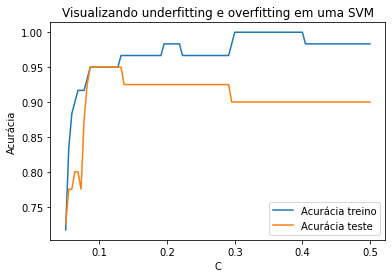

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

sscaler = StandardScaler()
X_train_scaled = sscaler.fit_transform(X_train)
X_test_scaled = sscaler.transform(X_test)

train_accs = []
test_accs = []

c_values = []

for C in np.linspace(0.05, 0.5, 100):
    c_values.append(C)
    svc = SVC(kernel='rbf', C=C)
    svc.fit(X_train_scaled, y_train)
    
    train_pred = svc.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, train_pred)
    train_accs.append(train_acc)
    
    test_pred = svc.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    test_accs.append(test_acc)
    
plt.plot(c_values, train_accs, label='Acurácia treino')
plt.plot(c_values, test_accs, label='Acurácia teste')
plt.xlabel('C')
plt.ylabel('Acurácia')
plt.title('Visualizando underfitting e overfitting em uma SVM')
plt.legend()
plt.show()

## Árvore de decisão (Decision Tree -- DT)


_In a Nutshell:_ Árvores de decisão buscam particionar o espaço dos atributos descritivos de modo a isolar regiões homogêneas. Se baseiam na estratégia de "dividir para conquistar". As árvores são construídas seguindo uma abordagem _top-down_ , em outras palavras, do nó raiz até as folhas. O atributo com maior capacidade discriminativa é escolhido para ser a raiz.
As partições feitas nos atributos de entrada são ortogonais.

Dada a simplicidade do conjunto utilizado, retornamos para os dados originais (incluimos todos os exemplos e classes). Podemos observar uma situação de *underfitting*, no entanto, o *overfitting* não é facilmente observável nesse caso.

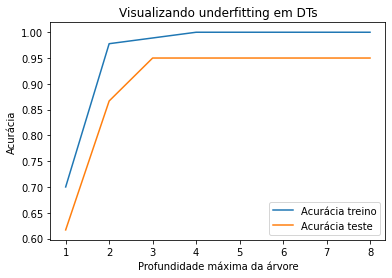

In [11]:
from sklearn.tree import DecisionTreeClassifier

X, y = iris['data'], iris['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

train_accs = []
test_accs = []

d_values = []

for d in range(1, 9):
    d_values.append(d)
    dt = DecisionTreeClassifier(max_depth=d, random_state=2)
    dt.fit(X_train, y_train)
    
    train_pred = dt.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accs.append(train_acc)
    
    test_pred = dt.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_accs.append(test_acc)
    
plt.plot(d_values, train_accs, label='Acurácia treino')
plt.plot(d_values, test_accs, label='Acurácia teste')
plt.xlabel('Profundidade máxima da árvore')
plt.ylabel('Acurácia')
plt.title('Visualizando underfitting em DTs')
plt.legend()
plt.show()